In [71]:
import os
import json
import copy
import pandas as pd
import math
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, HTML
from shutil import get_terminal_size


mpl.rc("text", usetex=True)
mpl.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb}\usepackage{calrsfs}\DeclareMathAlphabet{\pazocal}{OMS}{zplm}{m}{n}\SetMathAlphabet\pazocal{bold}{OMS}{zplm}{bx}{n}\newcommand{\mth}{\mathcal{A}}\newcommand{\pzc}{\pazocal{A}}')


FAKE = {
    "mip": False,
    "has_mipgap": None,
    "mipgap": None,
    "runtime_ms": None,
    "status": None,
}


In [35]:
def flatten_dict(d, prefix):
    is_dict = isinstance(d, dict)

    newdict = dict()
    if is_dict:
        for k, v in d.items():
            nk = f"{prefix}.{k}"
            newdict[nk] = copy.deepcopy(v)
    return newdict


def flatten_list(d, prefix):
    is_list = isinstance(d, list)

    newdict = dict()
    if is_list:
        r = []
        for i, v in enumerate(d):
            nk = f"{prefix}[{i}]"
            r.append(flatten_dict(v, nk))
        for dic in r:
            newdict = newdict | dic

    return newdict


In [54]:
FOLDER = "./results"
PREFIX = "esvis-ds"

folders_with_call_file = []

for subdir, dirs, files in os.walk(FOLDER):
    if "call.json" in files and subdir.startswith(os.path.join(FOLDER, PREFIX)):
        folders_with_call_file.append(subdir)

calls = []
for dir in folders_with_call_file:
    callfile = os.path.join(dir, "call.json")
    with open(callfile, "r") as f:
        call = json.load(f)
        call = call | flatten_dict(call["ctx"], "ctx")
        del call["ctx"]
        if "metrics" in call:
            call = call | flatten_list(call["metrics"], "metrics")
            del call["metrics"]

        # also merge the embedding metrics
        embedding_metrics = None
        try:
            with open(os.path.join(dir, 'metrics_embedding.json')) as f:
                embedding_metrics = json.load(f)
                call = call | embedding_metrics[0]
        except:
            pass

        # merge also the additional files
        for ilp_status_file in ["connect", "overlapremoval", "route", 'layout']:
            filename = f"ilp_status_{ilp_status_file}_0.json"
            filepath = os.path.join(dir, filename)
            status_file_exists = os.path.exists(filepath)
            if status_file_exists:
                with open(filepath, "r") as f:
                    status_file_data = flatten_dict(
                        json.load(f), f"ilp_{ilp_status_file}"
                    )
                    call = call | status_file_data
            else:
                call = call | FAKE
        calls.append(call)

df = pd.DataFrame(data=calls)


In [88]:
# post process

df["success"] = df.success.astype("bool")
df['dataset'] = df['ctx.general.dataset'].astype(str).map(lambda s:s[ s.index('_') + 1 : s.index('_') + 1 + s[s.index('_') + 1:].index('_')])
df['duration_s'] = df['duration_ms'].astype(float).map(lambda d: d / 1000)
df['duration_m'] = df['duration_s'].astype(float).map(lambda d: d / 60)

df[['M1 [EA, k=5]', 'M2 [EA, k=5]']] = df['EA: (M1, M2) [k=10%]'].apply(pd.Series)
df[['M1 [SR, k=5]', 'M2 [SR, k=5]']] = df['SR: (M1, M2) [k=10%]'].apply(pd.Series)

df['M1 [EA, k=5] avg'] = (df['M1 [EA, k=5]'] + df['M1 [SR, k=5]']) / 2
df['M2 [EA, k=5] avg'] = (df['M2 [EA, k=5]'] + df['M2 [SR, k=5]']) / 2

#print(df.head())

<Axes: xlabel='dataset', ylabel='ctx.connect.connecter-ctx.route.router-ctx.layout.overlapremover-ctx.general.subsupporttype'>

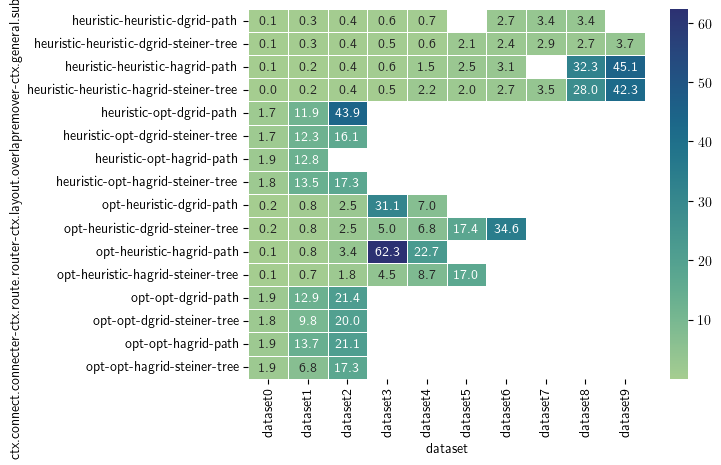

In [ ]:
import matplotlib.pyplot as plt

weight = 0.5
good_runs = df[(df["success"] == True) & (df["ctx.general.weight"] == weight)]
sns.heatmap(
    good_runs.pivot_table(
        index=[
            "ctx.connect.connecter",
            "ctx.route.router",
            "ctx.layout.overlapremover",
            "ctx.general.subsupporttype",
        ],
        columns=["dataset"],
        values="duration_m",
        aggfunc='median',
    ),
    linewidth=0.5,
    annot=True,
    fmt=".1f",
    cmap="crest",
)


Text(0, 0.5, '$M_1 (EA + SR)$')

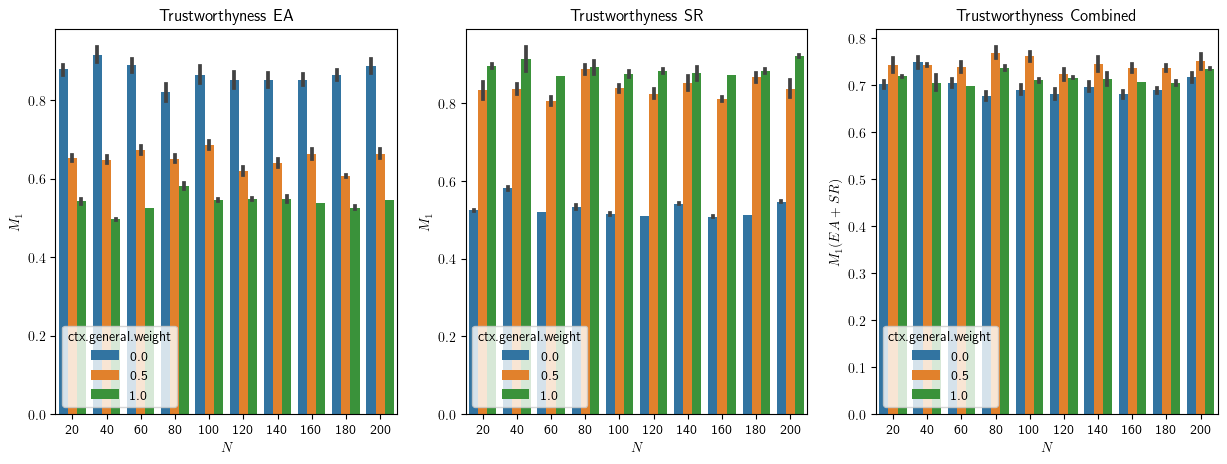

In [89]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

axes[0].set_title('Trustworthyness EA')
axes[1].set_title('Trustworthyness SR')
axes[2].set_title('Trustworthyness Combined')

sns.barplot(data=df, x="dataset", y="M1 [EA, k=5]", hue="ctx.general.weight",  ax=axes[0])
sns.barplot(data=df, x="dataset", y="M1 [SR, k=5]", hue="ctx.general.weight",  ax=axes[1])
sns.barplot(data=df, x="dataset", y="M1 [EA, k=5] avg", hue="ctx.general.weight",  ax=axes[2])

labels = range(20,201, 20)

axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels)
axes[2].set_xticklabels(labels)
axes[0].set_xlabel("$N$")
axes[1].set_xlabel("$N$")
axes[2].set_xlabel("$N$")
axes[0].set_ylabel("$M_1$")
axes[1].set_ylabel("$M_1$")
axes[2].set_ylabel("$M_1 (EA + SR)$")

Text(0, 0.5, '$M_2 (EA + SR)$')

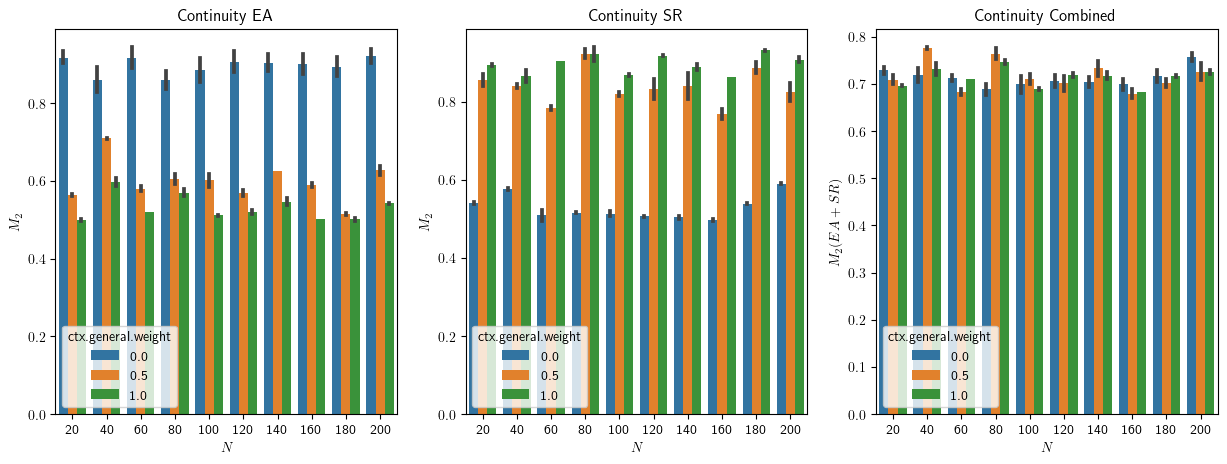

In [87]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

axes[0].set_title('Continuity EA')
axes[1].set_title('Continuity SR')
axes[2].set_title('Continuity Combined')

sns.barplot(data=df, x="dataset", y="M2 [EA, k=5]", hue="ctx.general.weight",  ax=axes[0])
sns.barplot(data=df, x="dataset", y="M2 [SR, k=5]", hue="ctx.general.weight",  ax=axes[1])
sns.barplot(data=df, x="dataset", y="M2 [EA, k=5] avg", hue="ctx.general.weight",  ax=axes[2])

labels = range(20,201, 20)

axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels)
axes[2].set_xticklabels(labels)
axes[0].set_xlabel("$N$")
axes[1].set_xlabel("$N$")
axes[2].set_xlabel("$N$")
axes[0].set_ylabel("$M_2$")
axes[1].set_ylabel("$M_2$")
axes[2].set_ylabel("$M_2 (EA + SR)$")

/home/mwallinger/anaconda3/envs/ensemble/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/mwallinger/anaconda3/envs/ensemble/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/mwallinger/anaconda3/envs/ensemble/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


Text(0, 0.5, '\\# Line Crossings')

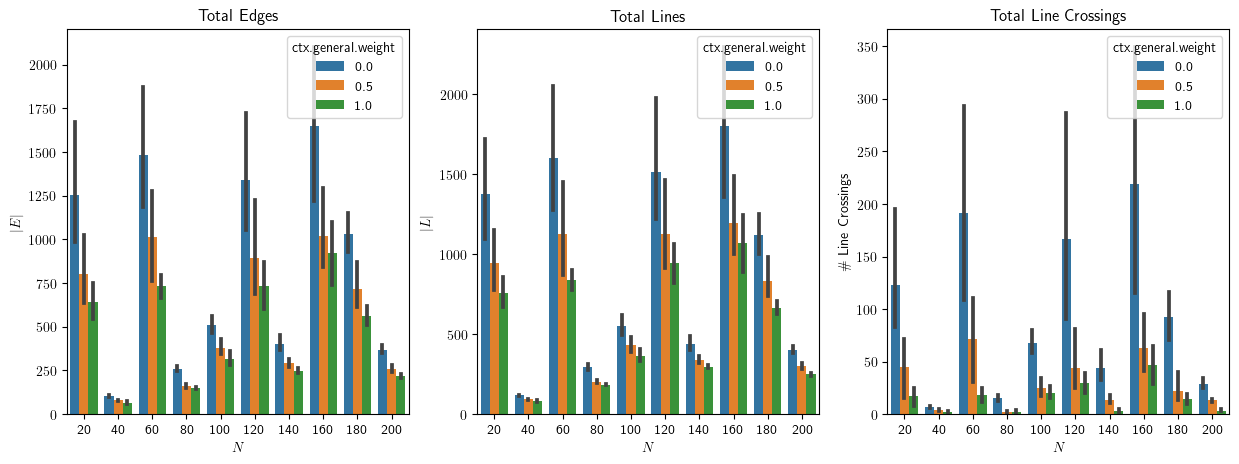

In [97]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

axes[0].set_title('Total Edges')
axes[1].set_title('Total Lines')
axes[2].set_title('Total Line Crossings')

sns.barplot(data=df, x="dataset", y="metrics[0].total_edges", hue="ctx.general.weight",  ax=axes[0], estimator='mean')
sns.barplot(data=df, x="dataset", y="metrics[0].total_lines", hue="ctx.general.weight",  ax=axes[1], estimator='mean')
sns.barplot(data=df, x="dataset", y="metrics[0].total_line_crossings", hue="ctx.general.weight",  ax=axes[2], estimator='mean'

labels = range(20,201, 20)

axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels)
axes[2].set_xticklabels(labels)
axes[0].set_xlabel("$N$")
axes[1].set_xlabel("$N$")
axes[2].set_xlabel("$N$")
axes[0].set_ylabel("$|E|$")
axes[1].set_ylabel("$|L|$")
axes[2].set_ylabel("\# Line Crossings")